<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/crnn/Copy_of_CRNN_Final_Exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [ ]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI/English_Indian_Melspec_Img"

aug = False

if aug:
    train_set_folders = ["ps_1_dur_10_npy",
                         "ps_1_dur_10_npy",
                         "gn_0.05_dur_10_npy"]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

## Imports and Colab Mount

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Utility Function Definitions

train_data_components = []
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

In [ ]:
# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  test_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "test"), loader=numpy_loader,extensions='.npy',transform=data_transform) 

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return raw_train_data, val_data, test_data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english','india']
    #classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Data Gen

In [ ]:
train_data, val_data, test_data = generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

RuntimeError: ignored

In [ ]:
from collections import Counter

print(dict(Counter(train_data.targets)))
train_data.classes

{0: 126, 1: 162, 2: 184}


['english', 'india', 'mandarin']

## Train Func

In [ ]:
def train_crnn_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    best_val_acc = 0 
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.float().cuda()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_cnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        if epoch>30 and val_acc[-1]>best_val_acc:
            print("SAVED MODEL")
            model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
            checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, str(epoch+1))
            full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
            try:
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
            except FileNotFoundError:
                os.makedirs(full_checkpoint_path)
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        if val_acc[-1]>best_val_acc:
            best_val_acc = val_acc[-1]
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

## Experiments

### EXP 1 - CRNN: 3classes data 

27 Batch, epoch 50, lr 0.00005, 

dataset: raw_10s_3classes_npy, w/out aug 

conv 16, 32, fc 20,10 hidden size 50 


In [ ]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

Using CUDA
Epoch:  0 Train Accuracy:  0.38344226579520696 Val Accuracy:  0.37037037037037035 Progress:   2.00  % Time Elapsed:   3.95 s 
Epoch 0 Finished.  Time per Epoch:   3.95 s 
Epoch:  1 Train Accuracy:  0.45098039215686275 Val Accuracy:  0.3333333333333333 Progress:   4.00  % Time Elapsed:   7.96 s 
Epoch 1 Finished.  Time per Epoch:   3.98 s 
Epoch:  2 Train Accuracy:  0.4357298474945534 Val Accuracy:  0.35185185185185186 Progress:   6.00  % Time Elapsed:  11.97 s 
Epoch 2 Finished.  Time per Epoch:   3.99 s 
Epoch:  3 Train Accuracy:  0.5315904139433552 Val Accuracy:  0.3888888888888889 Progress:   8.00  % Time Elapsed:  16.00 s 
Epoch 3 Finished.  Time per Epoch:   4.00 s 
Epoch:  4 Train Accuracy:  0.5403050108932462 Val Accuracy:  0.46296296296296297 Progress:  10.00  % Time Elapsed:  19.92 s 
Epoch 4 Finished.  Time per Epoch:   3.98 s 
Epoch:  5 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5555555555555556 Progress:  12.00  % Time Elapsed:  23.89 s 
Epoch 5 Finishe

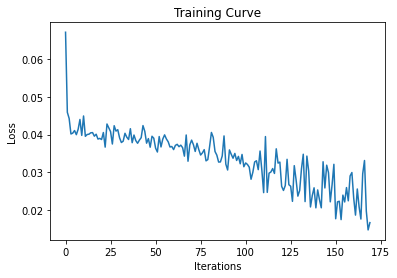

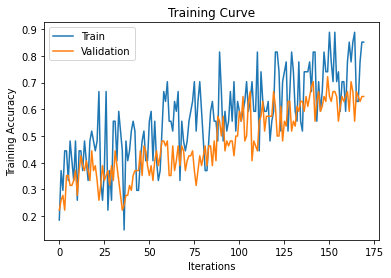

Epoch:  10 Train Accuracy:  0.7821350762527233 Val Accuracy:  0.7037037037037037 Progress:  22.00  % Time Elapsed:  44.13 s 
Epoch 10 Finished.  Time per Epoch:   4.01 s 
Epoch:  11 Train Accuracy:  0.803921568627451 Val Accuracy:  0.7037037037037037 Progress:  24.00  % Time Elapsed:  48.06 s 
Epoch 11 Finished.  Time per Epoch:   4.00 s 
Epoch:  12 Train Accuracy:  0.8257080610021786 Val Accuracy:  0.6296296296296297 Progress:  26.00  % Time Elapsed:  52.00 s 
Epoch 12 Finished.  Time per Epoch:   4.00 s 
Epoch:  13 Train Accuracy:  0.8605664488017429 Val Accuracy:  0.6481481481481481 Progress:  28.00  % Time Elapsed:  55.93 s 
Epoch 13 Finished.  Time per Epoch:   4.00 s 
Epoch:  14 Train Accuracy:  0.8867102396514162 Val Accuracy:  0.7037037037037037 Progress:  30.00  % Time Elapsed:  59.92 s 
Epoch 14 Finished.  Time per Epoch:   3.99 s 
Epoch:  15 Train Accuracy:  0.8888888888888888 Val Accuracy:  0.7037037037037037 Progress:  32.00  % Time Elapsed:  63.92 s 
Epoch 15 Finished.  T

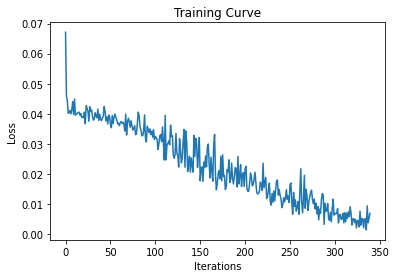

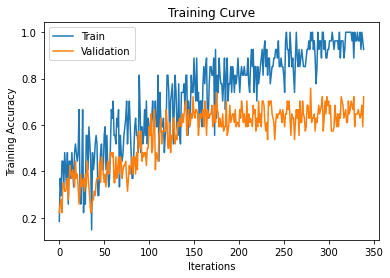

Epoch:  20 Train Accuracy:  0.9847494553376906 Val Accuracy:  0.6296296296296297 Progress:  42.00  % Time Elapsed:  84.23 s 
Epoch 20 Finished.  Time per Epoch:   4.01 s 
Epoch:  21 Train Accuracy:  0.9912854030501089 Val Accuracy:  0.6111111111111112 Progress:  44.00  % Time Elapsed:  88.42 s 
Epoch 21 Finished.  Time per Epoch:   4.02 s 
Epoch:  22 Train Accuracy:  0.9934640522875817 Val Accuracy:  0.6111111111111112 Progress:  46.00  % Time Elapsed:  92.54 s 
Epoch 22 Finished.  Time per Epoch:   4.02 s 
Epoch:  23 Train Accuracy:  0.9956427015250545 Val Accuracy:  0.7777777777777778 Progress:  48.00  % Time Elapsed:  96.45 s 
Epoch 23 Finished.  Time per Epoch:   4.02 s 
Epoch:  24 Train Accuracy:  1.0 Val Accuracy:  0.5370370370370371 Progress:  50.00  % Time Elapsed:  100.27 s 
Epoch 24 Finished.  Time per Epoch:   4.01 s 
Epoch:  25 Train Accuracy:  0.9956427015250545 Val Accuracy:  0.7037037037037037 Progress:  52.00  % Time Elapsed:  104.24 s 
Epoch 25 Finished.  Time per Epoc

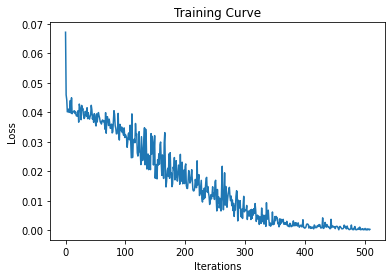

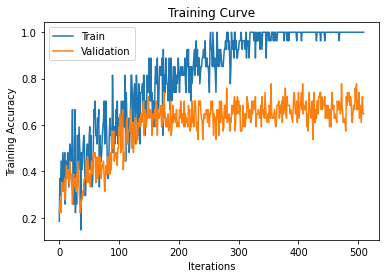

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  62.00  % Time Elapsed:  124.38 s 
Epoch 30 Finished.  Time per Epoch:   4.01 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  64.00  % Time Elapsed:  128.30 s 
Epoch 31 Finished.  Time per Epoch:   4.01 s 
Epoch:  32 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  66.00  % Time Elapsed:  132.22 s 
Epoch 32 Finished.  Time per Epoch:   4.01 s 
Epoch:  33 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  68.00  % Time Elapsed:  136.13 s 
Epoch 33 Finished.  Time per Epoch:   4.00 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.6296296296296297 Progress:  70.00  % Time Elapsed:  140.23 s 
Epoch 34 Finished.  Time per Epoch:   4.01 s 
Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.7407407407407407 Progress:  72.00  % Time Elapsed:  144.20 s 
Epoch 35 Finished.  Time per Epoch:   4.01 s 
Epoch:  36 Train Accuracy:  1.0 Val Accuracy:  0.740740740

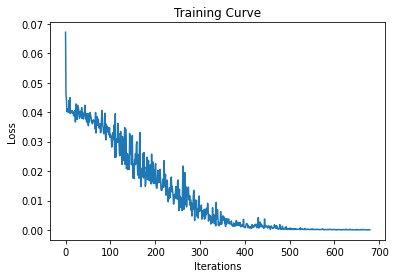

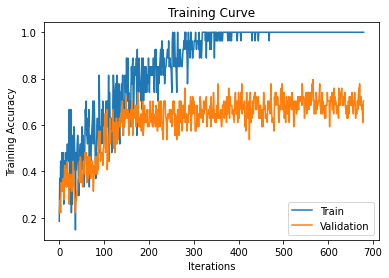

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.7222222222222222 Progress:  82.00  % Time Elapsed:  164.39 s 
Epoch 40 Finished.  Time per Epoch:   4.01 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  84.00  % Time Elapsed:  168.40 s 
Epoch 41 Finished.  Time per Epoch:   4.01 s 
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.7962962962962963 Progress:  86.00  % Time Elapsed:  172.37 s 
Epoch 42 Finished.  Time per Epoch:   4.01 s 
SAVED MODEL
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.6666666666666666 Progress:  88.00  % Time Elapsed:  176.50 s 
Epoch 43 Finished.  Time per Epoch:   4.01 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  90.00  % Time Elapsed:  180.52 s 
Epoch 44 Finished.  Time per Epoch:   4.01 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.6851851851851852 Progress:  92.00  % Time Elapsed:  184.50 s 
Epoch 45 Finished.  Time per Epoch:   4.01 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy: 

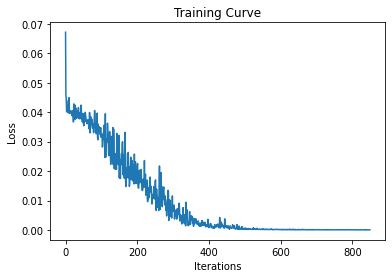

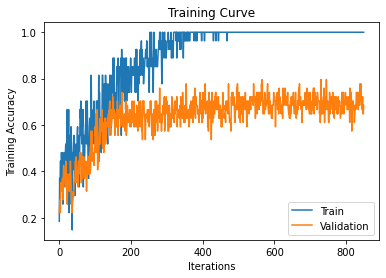

Finished Training
Total time:   200.85 s  Time per Epoch:   4.02 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_Final_Exp_1_3classes_raw",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

### EXP 2 - CRNN: 3classes data 

27 Batch, epoch 50, lr 0.00005, 

dataset: raw_10s_3classes_npy, w/ aug 

conv 16, 32, fc 20,10 hidden size 50 

Using CUDA
Epoch:  0 Train Accuracy:  0.39215686274509803 Val Accuracy:  0.3888888888888889 Progress:   2.00  % Time Elapsed:  131.65 s 
Epoch 0 Finished.  Time per Epoch:  131.65 s 
Epoch:  1 Train Accuracy:  0.4422657952069717 Val Accuracy:  0.42592592592592593 Progress:   4.00  % Time Elapsed:  136.27 s 
Epoch 1 Finished.  Time per Epoch:  68.14 s 
Epoch:  2 Train Accuracy:  0.5010893246187363 Val Accuracy:  0.4074074074074074 Progress:   6.00  % Time Elapsed:  139.91 s 
Epoch 2 Finished.  Time per Epoch:  46.64 s 
Epoch:  3 Train Accuracy:  0.5337690631808278 Val Accuracy:  0.42592592592592593 Progress:   8.00  % Time Elapsed:  143.58 s 
Epoch 3 Finished.  Time per Epoch:  35.90 s 
Epoch:  4 Train Accuracy:  0.5969498910675382 Val Accuracy:  0.5185185185185185 Progress:  10.00  % Time Elapsed:  147.33 s 
Epoch 4 Finished.  Time per Epoch:  29.47 s 
Epoch:  5 Train Accuracy:  0.5925925925925926 Val Accuracy:  0.5370370370370371 Progress:  12.00  % Time Elapsed:  151.31 s 
Epoch 5 Fi

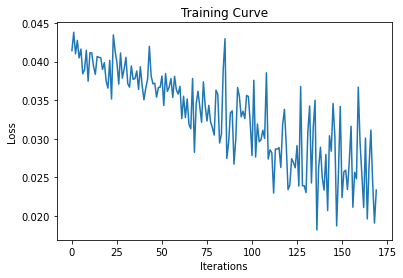

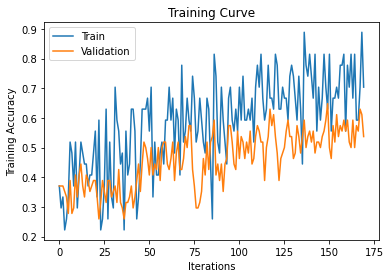

Epoch:  10 Train Accuracy:  0.7472766884531591 Val Accuracy:  0.5555555555555556 Progress:  22.00  % Time Elapsed:  170.46 s 
Epoch 10 Finished.  Time per Epoch:  15.50 s 
Epoch:  11 Train Accuracy:  0.7189542483660131 Val Accuracy:  0.6111111111111112 Progress:  24.00  % Time Elapsed:  174.14 s 
Epoch 11 Finished.  Time per Epoch:  14.51 s 
Epoch:  12 Train Accuracy:  0.7712418300653595 Val Accuracy:  0.5740740740740741 Progress:  26.00  % Time Elapsed:  177.74 s 
Epoch 12 Finished.  Time per Epoch:  13.67 s 
Epoch:  13 Train Accuracy:  0.7799564270152506 Val Accuracy:  0.5 Progress:  28.00  % Time Elapsed:  181.36 s 
Epoch 13 Finished.  Time per Epoch:  12.95 s 
Epoch:  14 Train Accuracy:  0.7886710239651417 Val Accuracy:  0.6666666666666666 Progress:  30.00  % Time Elapsed:  185.03 s 
Epoch 14 Finished.  Time per Epoch:  12.34 s 
Epoch:  15 Train Accuracy:  0.7952069716775599 Val Accuracy:  0.6481481481481481 Progress:  32.00  % Time Elapsed:  188.67 s 
Epoch 15 Finished.  Time per 

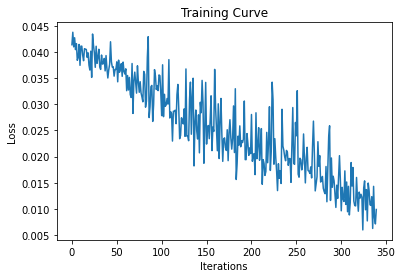

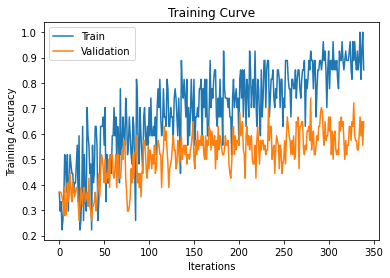

Epoch:  20 Train Accuracy:  0.9150326797385621 Val Accuracy:  0.5740740740740741 Progress:  42.00  % Time Elapsed:  207.08 s 
Epoch 20 Finished.  Time per Epoch:   9.86 s 
Epoch:  21 Train Accuracy:  0.9389978213507625 Val Accuracy:  0.5925925925925926 Progress:  44.00  % Time Elapsed:  210.74 s 
Epoch 21 Finished.  Time per Epoch:   9.58 s 
Epoch:  22 Train Accuracy:  0.9498910675381264 Val Accuracy:  0.6111111111111112 Progress:  46.00  % Time Elapsed:  214.44 s 
Epoch 22 Finished.  Time per Epoch:   9.32 s 
Epoch:  23 Train Accuracy:  0.9564270152505446 Val Accuracy:  0.7592592592592593 Progress:  48.00  % Time Elapsed:  218.18 s 
Epoch 23 Finished.  Time per Epoch:   9.09 s 
Epoch:  24 Train Accuracy:  0.9738562091503268 Val Accuracy:  0.6111111111111112 Progress:  50.00  % Time Elapsed:  221.89 s 
Epoch 24 Finished.  Time per Epoch:   8.88 s 
Epoch:  25 Train Accuracy:  0.9869281045751634 Val Accuracy:  0.6481481481481481 Progress:  52.00  % Time Elapsed:  225.65 s 
Epoch 25 Finis

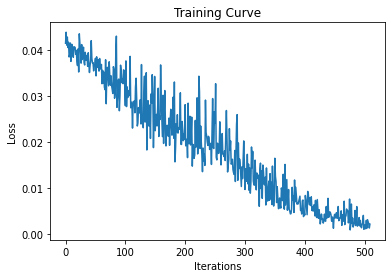

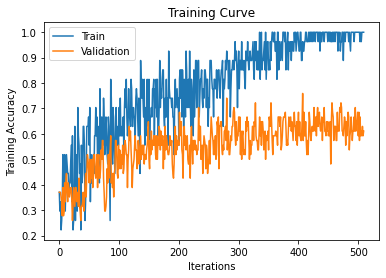

Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  62.00  % Time Elapsed:  244.45 s 
Epoch 30 Finished.  Time per Epoch:   7.89 s 
Epoch:  31 Train Accuracy:  0.9956427015250545 Val Accuracy:  0.6296296296296297 Progress:  64.00  % Time Elapsed:  248.16 s 
Epoch 31 Finished.  Time per Epoch:   7.75 s 
Epoch:  32 Train Accuracy:  0.9978213507625272 Val Accuracy:  0.6296296296296297 Progress:  66.00  % Time Elapsed:  251.74 s 
Epoch 32 Finished.  Time per Epoch:   7.63 s 
Epoch:  33 Train Accuracy:  0.9978213507625272 Val Accuracy:  0.5925925925925926 Progress:  68.00  % Time Elapsed:  255.35 s 
Epoch 33 Finished.  Time per Epoch:   7.51 s 
Epoch:  34 Train Accuracy:  1.0 Val Accuracy:  0.6111111111111112 Progress:  70.00  % Time Elapsed:  258.96 s 
Epoch 34 Finished.  Time per Epoch:   7.40 s 
Epoch:  35 Train Accuracy:  1.0 Val Accuracy:  0.6296296296296297 Progress:  72.00  % Time Elapsed:  262.60 s 
Epoch 35 Finished.  Time per Epoch:   7.29 s 
Epoch:  36 Tr

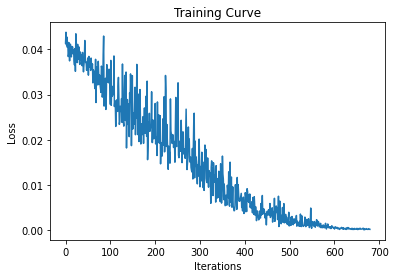

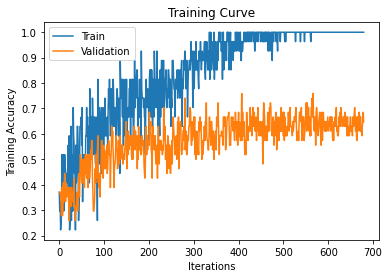

Epoch:  40 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  82.00  % Time Elapsed:  281.29 s 
Epoch 40 Finished.  Time per Epoch:   6.86 s 
Epoch:  41 Train Accuracy:  1.0 Val Accuracy:  0.5925925925925926 Progress:  84.00  % Time Elapsed:  284.95 s 
Epoch 41 Finished.  Time per Epoch:   6.78 s 
Epoch:  42 Train Accuracy:  1.0 Val Accuracy:  0.7037037037037037 Progress:  86.00  % Time Elapsed:  288.55 s 
Epoch 42 Finished.  Time per Epoch:   6.71 s 
Epoch:  43 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  88.00  % Time Elapsed:  292.19 s 
Epoch 43 Finished.  Time per Epoch:   6.64 s 
Epoch:  44 Train Accuracy:  1.0 Val Accuracy:  0.6111111111111112 Progress:  90.00  % Time Elapsed:  295.80 s 
Epoch 44 Finished.  Time per Epoch:   6.57 s 
Epoch:  45 Train Accuracy:  1.0 Val Accuracy:  0.6481481481481481 Progress:  92.00  % Time Elapsed:  299.45 s 
Epoch 45 Finished.  Time per Epoch:   6.51 s 
Epoch:  46 Train Accuracy:  1.0 Val Accuracy:  0.666666666

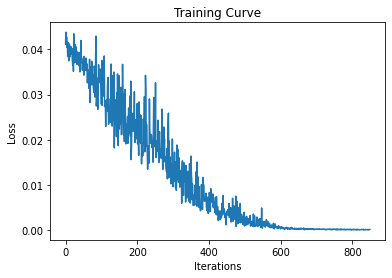

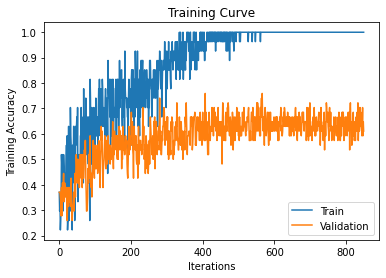

Finished Training
Total time:   314.55 s  Time per Epoch:   6.29 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005
# best so far: lr = 0.0005, hidden units = 8, hidden_size = 50 
# new best: lr = 0.0001 hidden units: 20,10, hidden_size = 50
# new new best: lr = 0.00005 hidden units 20, 10, hidden_size = 50, epoch 30-40 was good! conv 16 - 32 , 50 epochs 

config = {
    "name": "CRNN_Final_Exp_1_3classes_aug_V2",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## TESTING - Exp 1 and 2 Tests


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.0005 
num_workers = 1

config = {
    "name": "CRNN_Final_Exp_1_3classes_raw",
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 50,
    "nonlinearity": "relu",
    "dropout": 0,
}
net = CRNN(config)


model_path =  "/content/drive/My Drive/APS360 Group Project/model_checkpoints/model_CRNN_Final_Exp_1_3classes_aug_bs27_lr0.0005_epoch43/model_CRNN_Final_Exp_1_3classes_aug_bs27_lr0.0005_epoch43"
state = torch.load(model_path, map_location=torch.device('cpu'))
net.load_state_dict(state)

if torch.cuda.is_available():
  net = net.cuda()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
test_acc = get_accuracy_cnn(net, test_loader)

print("Test accuracy is: " + str(test_acc))

Using CUDA
Test accuracy is: 0.5308641975308642


In [ ]:
class CNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        #self.hidden_size = config.get("hidden_size", 0)
        #self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 32, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        #self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.conv_output_dim[1]*self.conv_output_dim[2], 20),
                                nn.Linear(20,10),
                            nn.Linear(10, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        #h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        #out, _ = self.rnn(x, h0)
        output = self.fc(x)
        return output